# 09. Zarr Access for NetCDF4 files

---

## Timing:
- Exercise: 45 minutes

---

## Summary

Zarr is an open source library for storing N-dimensional array data.  It supports multidimensional arrays with attributes and dimensions similar to NetCDF4, and it can be read by XArray.  Zarr is often used for data held in cloud object storage (like Amazon S3), because it is better optimized for these situations than NetCDF4.

The [zarr-eosdis-store library](https://github.com/nasa/zarr-eosdis-store) allows NASA EOSDIS NetCDF4 files to be read more efficiently by transferring only file metadata and data needed for computation in a small number of requests, rather than moving the whole file or making many small requests.  It works by making the files directly readable by the [Zarr Python library](https://zarr.readthedocs.io) and XArray across a network.  To use it, files must have a corresponding metadata file ending in `.dmrpp`, which increasingly true for cloud-accessible EOSDIS data.  https://github.com/nasa/zarr-eosdis-store

The zarr-eosdis-store library provides several benefits over downloading EOSDIS data files and accessing them using XArray, NetCDF4, or HDF5 Python libraries:

* It only downloads the chunks of data you actually read, so if you don't read all variables or the full spatiotemporal extent of a file, you usually won't spend time downloading those portions of the file
* It parallelizes and optimizes downloads for the portions of files you do read, so download speeds can be faster in general
* It automatically interoperates with Earthdata Login if you have a .netrc file set up
* It is aware of some EOSDIS cloud implementation quirks and provides caching that can save time for repeated requests to individual files

It can also be faster than using XArray pointing NetCDF4 files with s3:// URLs, depending on the file's internal structure, and is often more convenient.

Consider using this library when:
1. The portion of the data file you need to use is much smaller than the full file, e.g. in cases of spatial subsets or reading a single variable from a file containing several
1. s3:// URLs are not readily available
1. Code need to run outside of the AWS cloud or us-west-2 region or in a hybrid cloud / non-cloud manner
1. s3:// access using XArray seems slower than you would expect (possibly due to unoptimized internal file structure)
1. No readily-available, public, cloud-optimized version of the data exists already. The example we show _is_ also available as an AWS Public Dataset: https://registry.opendata.aws/mur/
1. Adding ".dmrpp" to the end of a data URL returns a file

### Objectives

1. Build on prior knowledge from CMR and Earthdata Login tutorials
2. Work through an example of using the EOSDIS Zarr Store to access data using XArray
3. Learn about the Zarr format and library for accessing data in the cloud
___



## Exercise

In this exercise, we will be using the eosdis-zarr-store library to aggregate and analyze a month of sea surface temperature for the Great Lakes region

### Set up

#### Import Required Packages

In [1]:
# Core libraries for this tutorial
# Available via `pip install zarr zarr-eosdis-store`
from eosdis_store import EosdisStore
import xarray as xr

# Other Python libraries
import numpy as np
import requests
from pqdm.threads import pqdm
from matplotlib import animation, pyplot as plt
from IPython.core.display import display, HTML

# Python standard library imports
from pprint import pprint

Also set the width / height for plots we show

In [2]:
plt.rcParams['figure.figsize'] = 12, 6

#### Set Dataset, Time, and Region of Interest

Look in PO.DAAC's cloud archive for Group for High Resolution Sea Surface Temperature (GHRSST) Level 4 Multiscale Ultrahigh Resolution (MUR) data

In [3]:
data_provider = 'POCLOUD'
mur_ShortName = 'MUR-JPL-L4-GLOB-v4.1'

Looking for data from the month of September over the Great Lakes

In [4]:
start_time = '2021-09-01T21:00:00Z'
end_time = '2021-09-30T20:59:59Z'

# Bounding box around the Great Lakes
lats = slice(41, 49)
lons = slice(-93, -76)

# Some other possibly interesting bounding boxes:

# Hawaiian Islands
# lats = slice(18, 22.5)
# lons = slice(-161, -154)

# Mediterranean Sea
# lats = slice(29, 45)
# lons = slice(-7, 37)

### Find URLs for the dataset and AOI

Set up a CMR granules search for our area of interest, as we saw in prior tutorials

In [5]:
CMR_OPS = 'https://cmr.earthdata.nasa.gov/search'
url = f'{CMR_OPS}/{"granules"}'

Search for granules in our area of interest, expecting one granule per day of September

In [6]:
response = requests.get(url, 
                        params={
                            'provider': data_provider,
                            'short_name': mur_ShortName, 
                            'temporal': f'{start_time},{end_time}',
                            'bounding_box': f'{lons.start},{lats.start},{lons.stop},{lats.stop}',
                            'page_size': 2000,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )

In [7]:
granules = response.json()['feed']['entry']

for granule in granules:
    print(granule["title"])

20210901090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20210902090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20210903090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20210904090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20210905090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20210906090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20210907090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20210908090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20210909090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20210910090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20210911090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20210912090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20210913090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20210914090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20210915090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20210916090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20210917090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20210918090000

In [8]:
pprint(granules[0])

{'boxes': ['-90 -180 90 180'],
 'browse_flag': False,
 'collection_concept_id': 'C1996881146-POCLOUD',
 'coordinate_system': 'CARTESIAN',
 'data_center': 'POCLOUD',
 'dataset_id': 'GHRSST Level 4 MUR Global Foundation Sea Surface Temperature '
               'Analysis (v4.1)',
 'day_night_flag': 'UNSPECIFIED',
 'granule_size': '9.059906005859375E-5',
 'id': 'G2113241213-POCLOUD',
 'links': [{'href': 's3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210901090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
            'hreflang': 'en-US',
            'rel': 'http://esipfed.org/ns/fedsearch/1.1/s3#',
            'title': 'This link provides direct download access via S3 to the '
                     'granule.'},
           {'href': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210901090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
            'hreflang': 'en-US',
            'rel': 'http://esipfed.org/ns/fedsearch/1.1/data

In [9]:
urls = []
for granule in granules:
    for link in granule['links']:
        if link['rel'].endswith('/data#'):
            urls.append(link['href'])
            break
pprint(urls)

['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210901090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210902090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210903090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210904090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210905090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210906090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cum

### Open and view our AOI without downloading a whole file

#### Check to see if we can use an efficient partial-access technique

In [10]:
response = requests.head(f'{urls[0]}.dmrpp')

print('Can we use EosdisZarrStore and XArray to access these files more efficiently?')
print('Yes' if response.ok else 'No')

Can we use EosdisZarrStore and XArray to access these files more efficiently?
Yes


Open our first URL using the Zarr library

In [11]:
url = urls[0]

ds = xr.open_zarr(EosdisStore(url), consolidated=False)

That's it!  No downloads, temporary credentials, or S3 filesystems.  Hereafter, we interact with the `ds` variable as with any XArray dataset.  We need not worry about the EosdisStore anymore.

View the file's variable structure

In [12]:
ds

,Array,Chunk
Bytes,2.41 GiB,7.99 MiB
Shape,"(1, 17999, 36000)","(1, 1023, 2047)"
Count,325 Tasks,324 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.41 GiB,7.99 MiB
Shape,"(1, 17999, 36000)","(1, 1023, 2047)"
Count,325 Tasks,324 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [13]:
ds.analysed_sst

,Array,Chunk
Bytes,2.41 GiB,7.99 MiB
Shape,"(1, 17999, 36000)","(1, 1023, 2047)"
Count,325 Tasks,324 Chunks
Type,float32,numpy.ndarray


In [14]:
sst = ds.analysed_sst.sel(lat=lats, lon=lons)
sst

<xarray.DataArray 'analysed_sst' (time: 1, lat: 801, lon: 1701)>
dask.array<getitem, shape=(1, 801, 1701), dtype=float32, chunksize=(1, 601, 1536), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 41.0 41.01 41.02 41.03 ... 48.97 48.98 48.99 49.0
  * lon      (lon) float32 -93.0 -92.99 -92.98 -92.97 ... -76.02 -76.01 -76.0
  * time     (time) datetime64[ns] 2021-09-01T09:00:00
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        \"Final\" version using Multi-Resolution Variational Anal...
    source:         MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRMTA_G-NAVO, A...

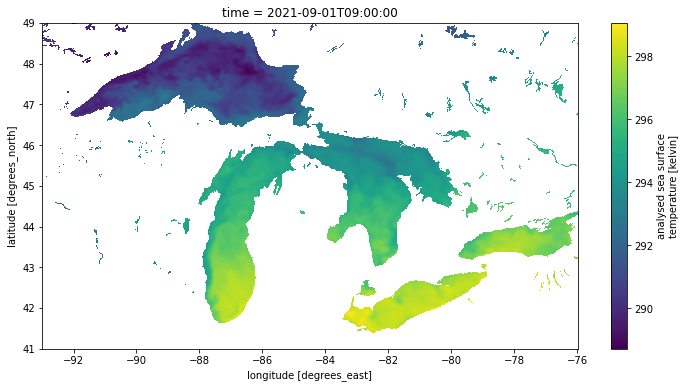

In [15]:
sst.plot()

### Aggregate and analyze 30 files

Set up a function to open all of our URLs as XArrays in parallel

In [16]:
def open_as_zarr_xarray(url):
    return xr.open_zarr(EosdisStore(url), consolidated=False)

datasets = pqdm(urls, open_as_zarr_xarray, n_jobs=30)

SUBMITTING | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/30 [00:00<?, ?it/s]

Combine the individual file-based datasets into a single xarray dataset with a time axis

In [17]:
ds = xr.concat(datasets, 'time')
ds

,Array,Chunk
Bytes,72.42 GiB,7.99 MiB
Shape,"(30, 17999, 36000)","(1, 1023, 2047)"
Count,19470 Tasks,9720 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,72.42 GiB,7.99 MiB
Shape,"(30, 17999, 36000)","(1, 1023, 2047)"
Count,19470 Tasks,9720 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


Look at the Analysed SST variable metadata

In [18]:
all_sst = ds.analysed_sst
all_sst

,Array,Chunk
Bytes,72.42 GiB,7.99 MiB
Shape,"(30, 17999, 36000)","(1, 1023, 2047)"
Count,19470 Tasks,9720 Chunks
Type,float32,numpy.ndarray


Create a dataset / variable that is only our area of interest and view its metadata

In [19]:
sst = ds.analysed_sst.sel(lat=lats, lon=lons)
sst

<xarray.DataArray 'analysed_sst' (time: 30, lat: 801, lon: 1701)>
dask.array<getitem, shape=(30, 801, 1701), dtype=float32, chunksize=(1, 601, 1536), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 41.0 41.01 41.02 41.03 ... 48.97 48.98 48.99 49.0
  * lon      (lon) float32 -93.0 -92.99 -92.98 -92.97 ... -76.02 -76.01 -76.0
  * time     (time) datetime64[ns] 2021-09-01T09:00:00 ... 2021-09-30T09:00:00
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        \"Final\" version using Multi-Resolution Variational Anal...
    source:         MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRMTA_G-NAVO, A...

XArray reads data lazily, i.e. only when our code actually needs it.  Up to this point, we haven't read any data values, only metadata.  The next line will force XArray to read the portions of the source files containing our area of interest.  Behind the scenes, the eosdis-zarr-store library is ensuring data is fetched as efficiently as possible.

Note: This line isn't strictly necessary, since XArray will automatically read the data we need the first time our code tries to use it, but calling this will make sure that we can read the data multiple times later on without re-fetching anything from the source files.

This line will take several seconds to complete, but since it is retrieving only about 50 MB of data from 22 GB of source files, several seconds constitutes a significant time, bandwidth, and disk space savings.

In [20]:
sst.load();

Now we can start looking at aggregations across the time dimension.  In this case, plot the standard deviation of the temperature at each point to get a visual sense of how much temperatures fluctuate over the course of the month.

/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


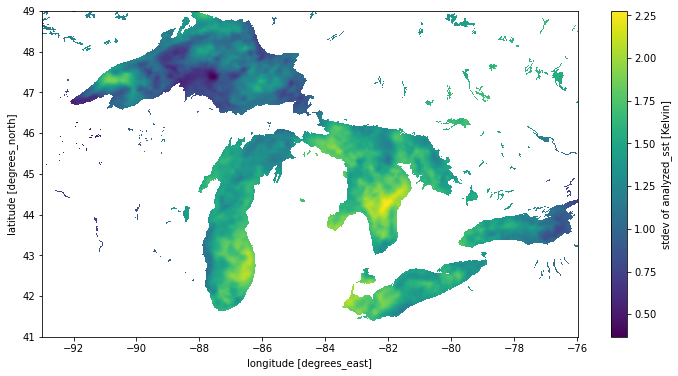

In [21]:
# We expect a warning here, from finding the standard deviation of arrays that contain all N/A values.
# numpy produces N/A for these points, though, which is exactly what we want.
stdev_sst = sst.std('time')
stdev_sst.name = 'stdev of analyzed_sst [Kelvin]'
stdev_sst.plot();

#### Interactive animation of a month of data

This section isn't as important to fully understand.  It shows us a way to get an interactive animation to see what we have retrieved so far

Define an animation function to plot the `i`th time step.  We need to make sure each plot is using the same color scale, set by `vmin` and `vmax` so the animation is consistent

In [22]:
sst_min = sst.min()
sst_max = sst.max()

def show_time_step(i):
    plt.clf()
    res = sst[i].plot.imshow(vmin=sst_min, vmax=sst_max)
    return (res,)

Render each time slice once and show it as an HTML animation with interactive controls

In [23]:
anim = animation.FuncAnimation(plt.gcf(), func=show_time_step, frames=len(sst))
display(HTML(anim.to_jshtml()))
plt.close()

### Supplemental: What's happening here?

For EOSDIS data in the cloud, we have begun producing a metadata sidecar file in a format called DMR++ that extracts all of the information about arrays, variables, and dimensions from data files, as well as the byte offsets in the NetCDF4 file where data can be found.  This information is sufficient to let the Zarr library read data from our NetCDF4 files, but it's in the wrong format.  zarr-eosdis-store knows how to fetch the sidecar file and transform it into something the Zarr library understands.  Passing it when reading Zarr using XArray or the Zarr library lets these libraries interact with EOSDIS data exactly as if they were Zarr stores in a way that's more optimal for reading data in the cloud.  Beyond this, the zarr-eosdis-store library makes some optimizations in the way it reads data to help make up for situations where the NetCDF4 file is not internally arranged well for cloud-based access patterns.